
<h2 id="data_class">CNN model to identify brain Tumors</h2>

    Created by Rafael A.H. in Oct. 2024
    Dataset by Preet Viradiya from Kaggle 2021

Convolutional neural network created with pytorch to detect and classify brain tumors from MRI scans

1.- Libraries>>>

In [48]:
#------------------------------------------------------------Libraries----------------------------------------------------------------
#Data Manipulation (General)
import matplotlib.pylab as plt                         
import numpy as np                                      
import os                                               
import pandas as pd
from PIL import Image
import time

#Data Manipulation (Pytorch)
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from collections import OrderedDict

#Pytorch model
import torch
import torch.nn as nn
from torch import optim


2.- Data obtention, I call upon the Dataset to bring forth the images which will be used to train and validate the model

In [49]:
#------------------------------------------------------------------------------------------------------------------------------------------
#Data call
Metadata_DF = pd.read_csv('metadata.csv')
print(Metadata_DF.head())

   Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)


With this information I have decided to work with jpg images which have a shape of 512x512 in RGB so 3 dimensions

Here is a function to transform the data and work with the images in any position, as well as transforming them to tensors and normalize them with the standars values of an RGB Image

In [50]:
#------------------------------------------------------------------------------------------------------------------------------------------
#Data transformation
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),#The image has a shape of 512, for optimization I reduced it
        transforms.Grayscale(num_output_channels=1), # Convert RGB to grayscale to set a single channel 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5],std = [0.5]) #Values standard for Grayscale single channel
   ]
)

For this part I am going to merge the images in one defining as positive those images where is a tumor and negative those which are healthy.

In [51]:
#Image and data merge
dir=''
positive="Brain Tumor"
negative='Healthy'

positive_file_path=os.path.join(dir,positive)
negative_file_path=os.path.join(dir,negative)
positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]

# Check for both lists have the same length
min_length = min(len(positive_files), len(negative_files))
positive_files = positive_files[:min_length]
negative_files = negative_files[:min_length]

# Combine and shuffle files
all_files = np.array(positive_files + negative_files)
labels = np.array([1] * min_length + [0] * min_length)

# Shuffle the dataset
indices = np.random.permutation(len(all_files))
all_files = all_files[indices]
labels = labels[indices]

# Convert labels to torch tensor
Y = torch.tensor(labels, dtype=torch.long)

# Print number of samples
number_of_samples = len(all_files)
print("Number of samples:", number_of_samples)

#Splitting data for training I will use 80% of the dataset and for validation I will use the other 20%
train_size = int(0.7 * number_of_samples)

train_files, val_files = all_files[:train_size], all_files[train_size:]
train_labels, val_labels = Y[:train_size], Y[train_size:]

print("Training samples: ", len(train_files))
print("Validation samples: ", len(val_files))

Number of samples: 4148
Training samples:  2903
Validation samples:  1245


Applying the transformation for the images and crating dataloaders

In [52]:
# Setting up the transformation and data loader of the images

# Custom dataset class to apply transformations
class BrainTumorDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
train_dataset = BrainTumorDataset(train_files, train_labels, transform=transform)
val_dataset = BrainTumorDataset(val_files, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Lets take a peak at some images to see if I did it right

Images shape: torch.Size([64, 1, 128, 128])
Labels shape: torch.Size([64])


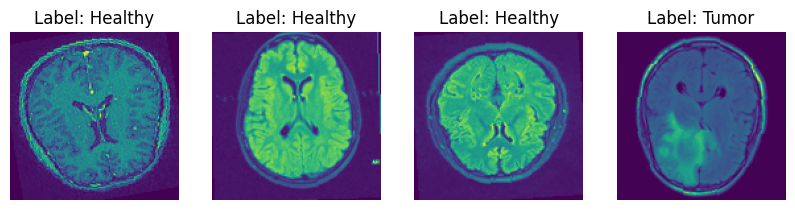

In [53]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print shapes to debug
print("Images shape:", images.shape)  # Should be (batch_size, C, H, W)
print("Labels shape:", labels.shape)   # Should be (batch_size,)

# Plot the images
num_images = min(4, len(images))  # Handle case when there are fewer than 2 images
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

for idx in range(num_images):
    image = images[idx].numpy().transpose((1, 2, 0))
    
    # Check for NaN or invalid values
    if np.any(np.isnan(image)) or np.any(np.isinf(image)):
        print("Invalid values found in image.")

    # Unnormalize
    image = image * np.array([0.5]) + np.array([0.5])
    image = np.clip(image, 0, 1)
    
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {'Tumor' if labels[idx] == 1 else 'Healthy'}")
    axes[idx].axis('off')

plt.show()


3.- Time to set and create the CNN model, 
but here is the trick, there are several architectures for Convolutional neural networks classics like resnet or VGG have been used for image recognition for quite a while, I could do a model from scratch but in this case I want to try approaching this dataset with Densely connected Networks architcture and I hope that my laptop survives. 

#First of all I have decided to use DenseNetworks but using only 3 dense blocks 2 transition layers and a lot of faith
<body>
<br>
----------------------------------------------------------------------------------------------------------------------------------------<br>
Input → Conv2D → BatchNorm → ReLU <br>
    &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 1<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Transition Layer<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 2<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Transition Layer<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 3<br>
       &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Global Average Pooling<br>
       &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Fully Connected Layer (Output)<br>
   </body>
   ---------------------------------------------------------------------------------------------------------------------------------------

*Transition Class*

In [54]:
#First I define the transition class for an average pooling of 2x2 and convoluttions 1x1 with relu as activation function
# to mantain the size of the feature map between transitions 

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


*Dense Layers Class*

In [55]:
#Each Dense block has dense layers so lets define them

# The convolution operation is performed to get new_features which are of size K or growth_rate.
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        
        # The first batch normalization and activation is for the input features
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        
        # Bottleneck convolution 
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
        
        # Then this second batch normalization and activation is for the bottleneck output
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        
        # I add a convolution for the growth output
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        
        # A little bit of optimization here
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient
        
    # The DenseLayer accepts an input, then it concatenates the input together and get bottleneck_output 
    def bn_function(self, inputs):
        "Bottleneck function"
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  
        return bottleneck_output

    # The forward function processes the input through a bottleneck layer followed by a convolution layer to obtain the new features
    def forward(self, input):  
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

*Dense block Class*

In [56]:
# The denseblock class will consist of multiple denselayers 

class _DenseBlock(nn.ModuleDict):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        
        # Here is the loop to create dense layer instances for each dense block defined
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    # Now lets define how the input data flows through the DenseBlock during the forward pass of the neural network.
    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

*Dense Network Class*

In [57]:
#The DenseNet class is a implementation of the DenseNet architecture, which main features I defined in the previous class

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), #Densenet-121 parameters by default
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=True):

        super(DenseNet, self).__init__()

        # Initial Convolution and pooling for the model
        self.features = nn.Sequential(OrderedDict([
            # Here it's defined 1 input for single channel Grayscale and passed the initial features
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            # Normalization, relu and maxpooling layers
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on the config you desire like densenet-121 or densenet 264 
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            #Call upon the class of Denseblock to create each block
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # Call upon transition layer between denseblocks as the architeqture configutration
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm 
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # fully connected layer for linear classification
        self.classifier = nn.Linear(num_features, num_classes)

        # Official initialization for wight and bias
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    # The forward method 
    def forward(self, x):
        # Passes the batch of images forwardo to get the features
        features = self.features(x)
        # Passes the features trough a relu function
        out = F.relu(features, inplace=True)
        # Ensures the output of the feature map stays the same 
        out = F.adaptive_avg_pool2d(out, (1, 1))
        # Flatten the tensor to 1 dimension 
        out = torch.flatten(out, 1)
        # Classifies the output in the fully conected layer
        out = self.classifier(out)
        return out

4.- Creating the model: so lets implement the model and see how it is

In [58]:
# Model instantiation with densenet 121 block_config=(6, 12, 24, 16) & bn_size=4
model = DenseNet()

# Print model summary
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

As you can see the model has 4 denseblocks as denseNet-121, with 6 layers in the first block, 12 layers in the second block, 24 layers in the third block and 16 layers in the last block. 

5.- Training the model: For now I have defined the training loader and the validation loader with a batch of 32 

In [59]:
# Number of epochs
num_epochs = 15

# Lists to plot over each epoch
loss_list = []
accuracy_list = []
start_time = time.time()

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Scheduler for early stopping and learning rate updates
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Average loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # average validation for loss and accuracy lists
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy}%")
    
    # appending the loss and acc
    loss_list.append(avg_val_loss)
    accuracy_list.append(accuracy)
    
    # Scheduler step
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping")
            break
    
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")


a:\Vscoding-for ai and more\Testing\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15, Loss: 2.396520575751429
Validation Loss: 0.5347524672746659, Accuracy: 82.00803212851406%
Epoch 2/15, Loss: 0.3787613238977349
Validation Loss: 0.30567447915673257, Accuracy: 88.27309236947791%
Epoch 3/15, Loss: 0.2465540914107924
Validation Loss: 0.2994403436779976, Accuracy: 86.66666666666667%
Epoch 4/15, Loss: 0.2167213644994342
Validation Loss: 0.23758438155055045, Accuracy: 90.36144578313252%
Epoch 5/15, Loss: 0.17659386652319328
Validation Loss: 0.23837649412453174, Accuracy: 90.60240963855422%
Epoch 6/15, Loss: 0.15340147588564002
Validation Loss: 0.14790279064327477, Accuracy: 94.53815261044177%
Epoch 7/15, Loss: 0.13985937955262867
Validation Loss: 0.13961687441915274, Accuracy: 95.7429718875502%
Epoch 8/15, Loss: 0.1258168112810539
Validation Loss: 0.09461207874119282, Accuracy: 96.62650602409639%
Epoch 9/15, Loss: 0.10381447013629519
Validation Loss: 0.174329848960042, Accuracy: 93.09236947791165%
Epoch 10/15, Loss: 0.101143187114402
Validation Loss: 0.1125778160

Lets plot the data in order to see how it learned between epoch

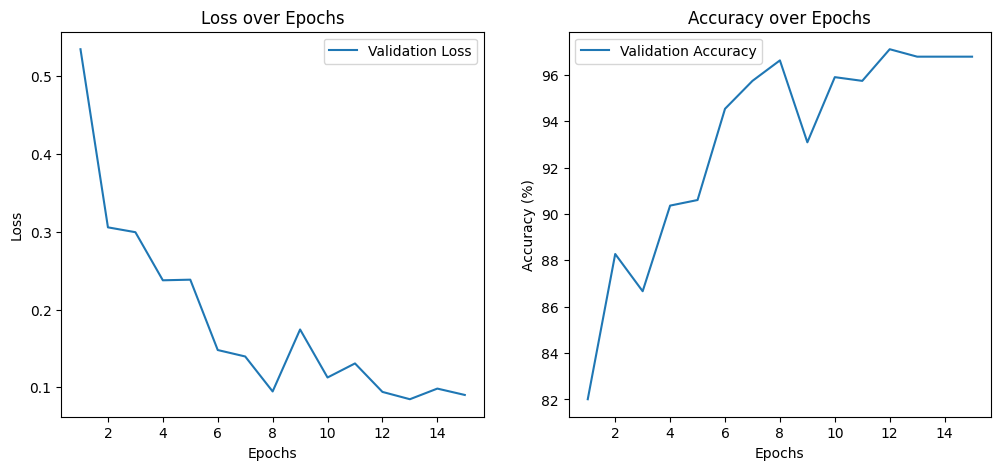

In [60]:
#------------------------------------------------------------------------------------------------------------------------------------------
#Visualisation
# Plotting the accuracy and loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

The model with the best accuracy was saved, so a 97.1 accuracy model was saved and is ready to use in any external data

If you wish to use this model remember to load the saved model in this repository:


You can load the model weights from the file `best_model.pth`